# Muscle-level ablation

To demostrate the importance of a particular muscle, we replace one of the individual muscles' activity with a noise signal and feed it into models, and then compare the generation difference.

In [49]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from scipy.spatial import procrustes
from tqdm.notebook import tqdm
import __init_paths

In [2]:
from config.st_dynamic_system import config, update_config
from models.st_gcn import STDynamicSystem
from dataset.muscle_sequence import get_muscle_sequences
from utils.visualize import VisualizeMuscle

In [3]:
os.chdir('..')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [10]:
# load the dataset
with open('./data/larva/ventral.pkl', 'rb') as fp:
    ventral_dataset = pickle.load(fp)

In [11]:
ventral_calcium_dfs = []
ventral_pose_dfs = []
for raw_item in ventral_dataset:
    df = raw_item['data']
    x_cols = [c for c in df.columns if c[2] != 'calcium']
    u_cols = [c for c in df.columns if c[2] == 'calcium']
    ventral_calcium_dfs.append(df[u_cols])
    ventral_pose_dfs.append(df[x_cols])

In [12]:
def load_model(model_file, config_file):
    params = {
        'cfg': config_file
    }
    update_config(config, params)
    _, adjacency, _ = get_muscle_sequences(config, is_train=False)

    model = STDynamicSystem(config, adjacency)
    model.cuda()
    model.load_checkpoint(model_file)
    return model

def inference_pose(config_file, model, initial_x, subsequent_u):
    params = {
        'cfg': config_file,
    }
    update_config(config, params)

    # normalize the input
    x_std = np.asarray(config.DATASET.X_STD)
    x_mean = np.asarray(config.DATASET.X_MEAN)
    u_std = np.asarray(config.DATASET.U_STD)
    u_mean = np.asarray(config.DATASET.U_MEAN)
    initial_x = (initial_x - x_mean[:, np.newaxis]) / x_std[:, np.newaxis]
    subsequent_u = (subsequent_u - u_mean[:, np.newaxis, np.newaxis]) / u_std[:, np.newaxis, np.newaxis]
    
    initial_x = torch.from_numpy(initial_x.astype(np.float32))
    subsequent_u = torch.from_numpy(subsequent_u.astype(np.float32))
    
    pred = model.predict(initial_x, subsequent_u)
    pred = pred.detach().cpu().numpy()
    pred = pred * x_std[:, np.newaxis, np.newaxis] + x_mean[:, np.newaxis, np.newaxis]
    return pred

In [13]:
def plot_results(pred_all, real_all, save_file, step=1, dpi=600):
    """Plot the result sequences of prediction and groundtruth
    
    :param pred_all: The predicted sequence [C, T, V]
    :param real_all: The groundtruth sequence [C, T, V]
    """
    time_steps = pred_all.shape[1]
    fig, axes = plt.subplots(nrows=2, ncols=time_steps,
                             figsize=(time_steps, 2), sharex=True)
    axes[0, 0].set_ylabel('Prediction')
    axes[1, 0].set_ylabel('Real')
    for i in range(0, time_steps):
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
    for i in range(0, time_steps, step):
        vis = VisualizeMuscle(pred_all[:, i].T)
        vis.show_motion(axes[0, i // step])
        vis_gt = VisualizeMuscle(real_all[:, i].T)
        vis_gt.show_motion(axes[1, i // step])
    fig.tight_layout()
    if save_file is not None:
        fig.savefig(save_file, dpi=dpi)

In [14]:
def to_cartesian_coords(data):
    """Transform the [length, width, angle, cx, cy] representation to cartesian coordinates
    
    :param data: [V, C]
    """
    polygons = data
    pose = []
    for i, p in enumerate(polygons):
        affine_transform = mtransforms.Affine2D()
        affine_transform.rotate_deg_around(x=p[3], y=p[4], degrees=p[2])
        xy = (p[3] - p[0]/2, p[4] - p[1]/2)
        width = p[0]
        length = p[1]
        rect = mpatches.Rectangle(xy, width, length, transform=affine_transform)
        coords = np.array([rect.get_xy(),
                           [rect.get_x() + rect.get_width(), rect.get_y()],
                           [rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()],
                           [rect.get_x(), rect.get_y() + rect.get_height()]])
        pose.append(coords)
    return np.array(pose)

def mae(p1, p2):
    """Calculate the pose mse based on their cartesian coordinates
    
    :param p1: [C, V]
    :param p2: [C, V]
    """
    p1_cartesian = to_cartesian_coords(p1)
    p2_cartesian = to_cartesian_coords(p2)
    mtx1, mtx2, disparity = procrustes(p1_cartesian.reshape(-1, 2), p2_cartesian.reshape(-1, 2))
    return disparity

In [15]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

## Ventral ablations

In [16]:
def muscle_ablation(model_file,
                    config_file,
                    selected_muscle,
                    x_dataset,
                    u_dataset):
    # dict for saving overall error according to the individual muscle ablation
    overall_errs = []

    model = load_model(model_file, config_file)
    for data_idx, (x_data, u_data) in enumerate(zip(x_dataset, u_dataset)):
        num_steps = len(x_data)
        if num_steps < 48:
            continue
        for s in range(num_steps - 48):
            x = x_data.copy().values[s:s+49, :]
            u = u_data.copy().values[s:s+49, :]
            if selected_muscle is not None:
                u[:, selected_muscle] = 0.0
            x = np.reshape(x, (len(x), -1, 5)).transpose((2, 0, 1))
            u = u[np.newaxis, :, :]
            x0 = x[:, 0]
            x = x[:, 1:]
            u = u[:, 1:]
            pred = inference_pose(config_file, model, x0, u)
            errs = [mae(p1, p2) for (p1, p2) in zip(pred.transpose(1, 2, 0), x.transpose(1, 2, 0))]
            overall_errs.extend(errs)
    return np.asarray(overall_errs)

In [87]:
model_file = './outputs/STDynamicSystem/Calcium2Muscle/ventral/checkpoint_latest.pth'
config_file = './experiments/st_dynamic_system/calcium2muscle/ventral.yaml'
data_index = 10
start_point = 10
x = ventral_pose_dfs[data_index].values[start_point:start_point+49, :]
u = ventral_calcium_dfs[data_index].values[start_point+1:start_point+49, :]
x = np.reshape(x, (len(x), -1, 5)).transpose((2, 0, 1))
u = u[np.newaxis, :, :]
x0 = x[:, 0]
x = x[:, 1:]
print(x0.shape, u.shape)

(5, 34) (1, 48, 34)


In [ ]:
ablated_errs = muscle_ablation(model_file, 
                               config_file, 
                               1, 
                               ventral_pose_dfs, 
                               ventral_calcium_dfs)

In [13]:
print(ablated_errs.shape)

(36576,)


In [14]:
ablated_errs_dict = {}
ablated_errs_dict['No'] = muscle_ablation(
    model_file, config_file, None, ventral_pose_dfs, ventral_calcium_dfs
)
num_muscles = ventral_calcium_dfs[0].shape[1]
for i in tqdm(range(num_muscles)):
    ablated_errs_dict[i] = muscle_ablation(
        model_file, config_file, i, ventral_pose_dfs, ventral_calcium_dfs
    )
with open('./results/ventral_individual_muscle_ablation_errs.pkl', 'wb') as fp:
    pickle.dump(ablated_errs_dict, fp)

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
print(np.mean(ablated_errs_dict['No']))
for i in range(num_muscles):
    print(np.mean(ablated_errs_dict[i]))

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
with open("./results/ventral_individual_muscle_ablation_errs.pkl", "rb") as fp:
    ablated_errs_dict = pickle.load(fp)

In [18]:
ablated_errs_dict['No'] = muscle_ablation(
    model_file, config_file, None, ventral_pose_dfs, ventral_calcium_dfs
)

In [19]:
errs_df = pd.DataFrame(ablated_errs_dict)

In [35]:
from natsort import natsorted

In [36]:
errs_df = errs_df.reindex(natsorted(errs_df.columns), axis=1)

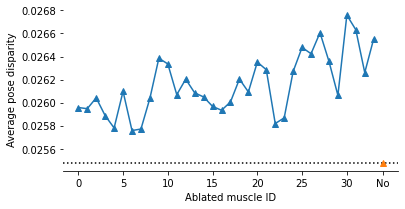

In [48]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(errs_df.columns[:-1], errs_df.values[:, :-1].mean(axis=0), marker='^')
ax.axhline(errs_df.values[:, -1].mean(), ls=':', color='black')
ax.plot(34, errs_df.values[:, -1].mean(), marker='^')
ax.set_ylabel("Average pose disparity")
ax.set_xlabel("Ablated muscle ID")
ax.set_xticks(list(np.arange(0, 34, 5, dtype=np.float32)) + [34])
ax.set_xticklabels(list(np.arange(0, 34, 5)) + ['No'])
sns.despine(left=True)
fig.savefig("./results/individual_muscle_albation_errs.pdf", bbox_inches='tight')

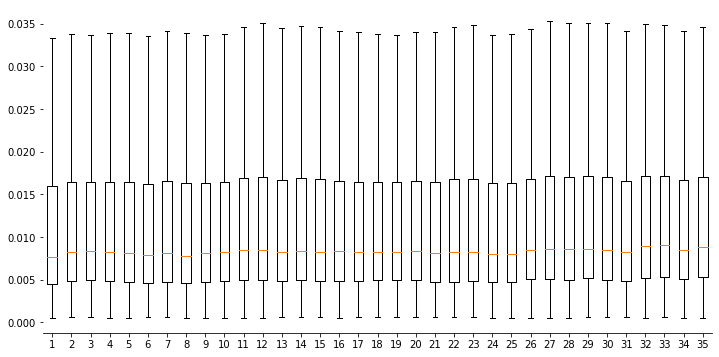

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(errs_df.values, showfliers=False)
sns.despine(left=True)
fig.savefig("./results/individual_muscle_albation_errs_box.pdf")

In [74]:
def show_muscle_ablation_heatmap(data, ax=None, muscle_remap=None, strength_levels=None): 
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if muscle_remap is None:
        polygons = data
    else:
        polygons = data[[muscle_remap[k] for k in muscle_remap], :]
    patches = []
    for i, p in enumerate(polygons):
        affine_transform = mtransforms.Affine2D()
        affine_transform.rotate_deg_around(x=p[3], y=p[4], degrees=p[2])
        xy = (p[3] - p[0]/2, p[4] - p[1]/2)
        width = p[0]
        length = p[1]
        patches.append(mpatches.Rectangle(xy, width, length, transform=affine_transform))

    plot_collection = PatchCollection(patches, alpha=1.0)
    if strength_levels is None:
        colors = 0.1 * np.arange(len(patches))
    else:
        norm = plt.Normalize()
        # colors = plt.cm.jet(norm(strength_levels))
        colors = norm(strength_levels)
        # colors = strength_levels
        plot_collection.set_cmap('hot')
    plot_collection.set_array(colors)
    ax.add_collection(plot_collection)
    xlim = [polygons[..., 3].min(), polygons[..., 3].max()]
    ylim = [polygons[..., 4].min(), polygons[..., 4].max()]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('equal')

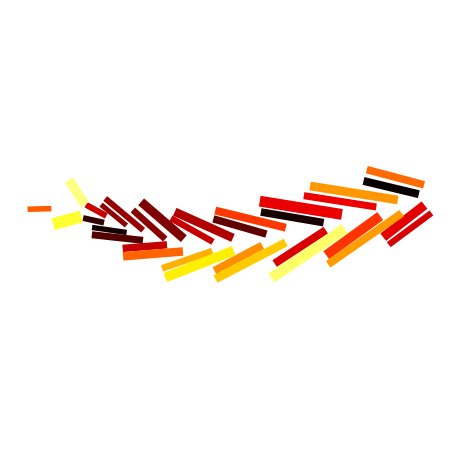

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_muscle_ablation_heatmap(x0.T, ax=ax, strength_levels=errs_df.values[:, :-1].mean(axis=0))
ax.axis('off')
fig.savefig("./results/individual_muscle_ablation_importance.pdf")